In [21]:
import os
import re
from functools import partial
from itertools import filterfalse
from pprint import pprint
from typing import Any, Tuple, Sequence, Iterable

import numpy as np
import pandas as pd

# topic modeling
import gensim
import gensim.corpora as corpora
import tqdm
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# text processing
from nltk.corpus import stopwords as nltk_stopwords
import spacy

# visualization
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from spacy.tokens import Token
from conversation import Conversation
from examples.cmv.reddit_conversation_parser import CMVConversationReader
from stance_classification.utils import iter_trees_from_lines
%matplotlib inline

# logging
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Stopwords


In [4]:
stopwords = nltk_stopwords.words("english")

# Get Data


In [7]:
trees_path = r"C:\Users\ronp\Documents\stance-classification\trees_2.0.txt"
total_trees = sum(1 for _ in iter_trees_from_lines(trees_path))
trees = tqdm.tqdm(iter_trees_from_lines(trees_path), total=total_trees)

cmv_reader = CMVConversationReader()
conversations = map(cmv_reader.parse, trees)

def extract_id_with_title(conversation: Conversation) -> Tuple[Any, str]:
    title = conversation.root.data["extra_data"]["title"]
    return conversation.root.node_id, title

ids, titles = zip(*map(extract_id_with_title, conversations))
pprint(list(zip(ids[:10], titles[:10])))

100%|██████████| 16306/16306 [00:58<00:00, 279.49it/s]


[('6kn9gy', "CMV: Short-term luxuries aren't bad"),
 ('7f53sk',
  'CMV: The biggest issue in America is the economical system and general wage '
  'system.'),
 ('6ozbfi', 'CMV: Change my view : LGBT PARENTING'),
 ('7f30fw',
  "CMV: Once an investment is promoted on reddit, it's too late to jump on"),
 ('6g7ct0', 'CMV: The bombing of Heroshema and Nagasaki were a mistake.'),
 ('715i08',
  'CMV:Halal &amp; Shechita butchers should be required to stun cattle prior '
  'to slaughter, religion should not be a pass for inhumane behavior.'),
 ('5u8mnq',
  'I believe it would be better off for the Earth, for humanity, and for the '
  'environment if a deadly disease wiped almost all of us out. CMV!'),
 ('5tmr76',
  'CMV: If the political split in the USA erupted into a civil war, it would '
  'be hopelessly one-sided in favor of conservatives/Trump supporters'),
 ('7fu0vw',
  'CMV:College students should not be allowed to sell their kidney for '
  'tuition'),
 ('4rx9zu',
  'CMV: A lot of racia

# clean & tokenize titles

In [12]:
# first remove CMV prefix from all titles:
def remove_cmv_prefix(title: str) -> str:
    title = title.strip()
    if title.startswith("CMV"):
        return title[3:]
    
    return title

cleaned_titles = map(remove_cmv_prefix, titles)

# tokenize and remove punctuations
tokenize = partial(gensim.utils.simple_preprocess, deacc=True)  # deacc=True removes punctuations)
titles_words = list(map(tokenize, cleaned_titles))
titles_words[0]



['short', 'term', 'luxuries', 'aren', 'bad']

# Create Bigram and Trigram models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(titles_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[titles_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

trigram_model[bigram_model[titles_words[0]]]



['short_term', 'luxuries', 'aren', 'bad']

In [19]:
# an example of common trigram terms
trigram_model.phrasegrams[:10]



{(b'short', b'term'): 302.16208791208794,
 (b'civil', b'war'): 984.0942105263157,
 (b'minimum', b'wage'): 9881.64453125,
 (b'universal', b'basic'): 3682.600446428571,
 (b'universal', b'basic_income'): 29460.80357142857,
 (b'universal_basic', b'income'): 1755.1117021276593,
 (b'cultural', b'appropriation'): 135866.29411764708,
 (b'getting', b'married'): 248.09097744360903,
 (b'muslim', b'ban'): 186.54511533242876,
 (b'double', b'standard'): 3093.384375,
 (b'death', b'penalty'): 5324.046044864226,
 (b'minimum', b'wage_is'): 13748.375,
 (b'vast', b'majority'): 3332.939393939394,
 (b'undocumented', b'immigrants'): 1793.266304347826,
 (b'united', b'states'): 13653.558620689655,
 (b'the_united', b'states'): 30996.33636363636,
 (b'systemic', b'racism'): 2820.1794871794873,
 (b'convince', b'me'): 706.7437751004016,
 (b'presidential', b'candidate'): 714.2012987012987,
 (b'mainstream', b'media'): 122.5345365418895,
 (b'donald', b'trump'): 5911.606789250354,
 (b'care', b'about'): 101.266607601973

# Process tokenized titles into a finalize form 

In [23]:
def remove_stopwords(tokens: Iterable[str]) -> Iterable[str]:
    return filterfalse(stopwords.__contains__, tokens)

def form_ngrams(tokens: Sequence[str]) -> Sequence[str]:
    return trigram_model[bigram_model[tokens]]

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def get_lemma(token: str) -> str:
    return nlp(token)[0].lemma_

def lemmatize(tokens: Sequence[str]) -> Iterable[str]:
    return list(map(get_lemma, tokens))

processed = map(remove_stopwords, titles_words)
processed = map(form_ngrams, processed)
processed = map(lemmatize, processed)

processed_titles = list(tqdm.tqdm(processed, total=len(titles_words)))
processed_titles[0]


['short_term', 'luxury', 'bad']

# Prepare dictionary and corpus for topic modeling


In [25]:
# Create Dictionary
id2word = corpora.Dictionary(processed_titles)

# Create Corpus
texts = processed_titles

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# Human readable format of corpus (term-frequency)
[(id2word[id], freq) for id, freq in corpus[0]]

[('bad', 1), ('luxury', 1), ('short_term', 1)]

# Building the Topic Model

In [106]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=300, 
                                           random_state=1919,
                                           update_every=50,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [107]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(44,
  '0.000*"emergence" + 0.000*"presumptive" + 0.000*"escalation" + '
  '0.000*"merge" + 0.000*"crumble" + 0.000*"empire" + 0.000*"extremist" + '
  '0.000*"zealots" + 0.000*"socio" + 0.000*"lasagna"'),
 (46,
  '0.000*"emergence" + 0.000*"presumptive" + 0.000*"escalation" + '
  '0.000*"merge" + 0.000*"crumble" + 0.000*"empire" + 0.000*"extremist" + '
  '0.000*"zealots" + 0.000*"socio" + 0.000*"lasagna"'),
 (11,
  '0.000*"emergence" + 0.000*"presumptive" + 0.000*"escalation" + '
  '0.000*"merge" + 0.000*"crumble" + 0.000*"empire" + 0.000*"extremist" + '
  '0.000*"zealots" + 0.000*"socio" + 0.000*"lasagna"'),
 (163,
  '0.000*"emergence" + 0.000*"presumptive" + 0.000*"escalation" + '
  '0.000*"merge" + 0.000*"crumble" + 0.000*"empire" + 0.000*"extremist" + '
  '0.000*"zealots" + 0.000*"socio" + 0.000*"lasagna"'),
 (236,
  '0.000*"emergence" + 0.000*"presumptive" + 0.000*"escalation" + '
  '0.000*"merge" + 0.000*"crumble" + 0.000*"empire" + 0.000*"extremist" + '
  '0.000*"zealots" + 0.0

# Evaluate with perplexity and coerence

In [108]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_titles, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -218.0789090758247

Coherence Score:  0.5329405196573862


perform LDA with 5 topics
5 topics has a coherence value of 0.3376617157921153
perform LDA with 10 topics
10 topics has a coherence value of 0.42636683028919925
perform LDA with 15 topics
15 topics has a coherence value of 0.39425032046269054
perform LDA with 20 topics
20 topics has a coherence value of 0.4196013282909622
perform LDA with 25 topics
25 topics has a coherence value of 0.4212741839339537
perform LDA with 30 topics
30 topics has a coherence value of 0.51891485210071
perform LDA with 35 topics
35 topics has a coherence value of 0.5514164545025976
perform LDA with 40 topics
40 topics has a coherence value of 0.5650420132302403
perform LDA with 45 topics
45 topics has a coherence value of 0.558467894826037
perform LDA with 50 topics
50 topics has a coherence value of 0.5663022819449796
perform LDA with 55 topics
55 topics has a coherence value of 0.5579581218690814
perform LDA with 60 topics
60 topics has a coherence value of 0.5508046335434593
perform LDA with 65 topics
65 t

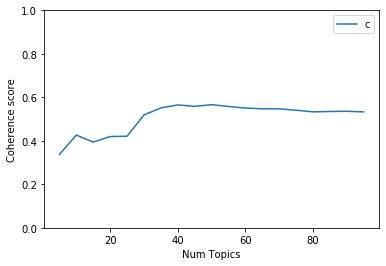

In [58]:
def compute_lda_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"perform LDA with {num_topics} topics")
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        coherence_values.append(coherencemodel.get_coherence())
        print(f"{num_topics} topics has a coherence value of {coherence_value}")

    return model_list, coherence_values

limit=100; start=5; step=5;
model_list, coherence_values = compute_lda_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_titles, start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.ylim([0, 1])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualize the topics-keywords

In [61]:
# Visualize the topics
best_model = model_list[0]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, id2word)
vis


KeyboardInterrupt: 

# Mallet Topic Modeling

In [111]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_home_path = os.path.abspath("mallet-2.0.8")
mallet_bin_path = os.path.join(mallet_home_path, "bin", "mallet")

os.environ['MALLET_HOME'] = mallet_home_path
print(mallet_bin_path)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_bin_path, corpus=corpus, num_topics=100, id2word=id2word)


C:\Users\ronp\PycharmProjects\cmv-stance-classification\stance_classification\topics\mallet-2.0.8\bin\mallet


In [112]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_titles, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(48,
  [('force', 0.04792332268370607),
   ('video', 0.04579339723109691),
   ('christian', 0.04472843450479233),
   ('place', 0.042598509052183174),
   ('regard', 0.04153354632587859),
   ('fear', 0.04046858359957402),
   ('refuse', 0.038338658146964855),
   ('datum', 0.02875399361022364),
   ('anymore', 0.024494142705005325),
   ('website', 0.023429179978700747)]),
 (39,
  [('-PRON-', 0.39752832131822863),
   ('uk', 0.04737384140061792),
   ('military', 0.027806385169927908),
   ('outdate', 0.025746652935118436),
   ('represent', 0.021627188465499485),
   ('constitution', 0.01956745623069001),
   ('eu', 0.01956745623069001),
   ('brexit', 0.017507723995880537),
   ('australia', 0.013388259526261586),
   ('taxpayer', 0.012358393408856848)]),
 (11,
  [('theory', 0.0546218487394958),
   ('science', 0.051470588235294115),
   ('reality', 0.04201680672268908),
   ('existence', 0.038865546218487396),
   ('brain', 0.031512605042016806),
   ('kill', 0.029411764705882353),
   ('evolution', 0.

In [51]:
def compute_mallet_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"perform LDA with {num_topics} topics")
        model = gensim.models.wrappers.LdaMallet(mallet_bin_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_value = coherencemodel.get_coherence()
        coherence_values.append(coherencemodel.get_coherence())
        print(f"{num_topics} topics has a coherence value of {coherence_value}")

    return model_list, coherence_values

In [52]:
# Can take a long time to run.
model_list, coherence_values = compute_mallet_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_titles, start=20, limit=100, step=5)


perform LDA with 20 topics
20 topics has a coherence value of 0.40339570194442664
perform LDA with 25 topics
25 topics has a coherence value of 0.4016547024031871
perform LDA with 30 topics
30 topics has a coherence value of 0.4332466485832491
perform LDA with 35 topics
35 topics has a coherence value of 0.42243897026997895
perform LDA with 40 topics
40 topics has a coherence value of 0.4309182050727065
perform LDA with 45 topics
45 topics has a coherence value of 0.43610635772515866
perform LDA with 50 topics
50 topics has a coherence value of 0.4257763995763694
perform LDA with 55 topics
55 topics has a coherence value of 0.4281829966473521
perform LDA with 60 topics
60 topics has a coherence value of 0.4341041115359084
perform LDA with 65 topics
65 topics has a coherence value of 0.43894272842082116
perform LDA with 70 topics
70 topics has a coherence value of 0.43859552522988127
perform LDA with 75 topics
75 topics has a coherence value of 0.44381269133924633
perform LDA with 80 to

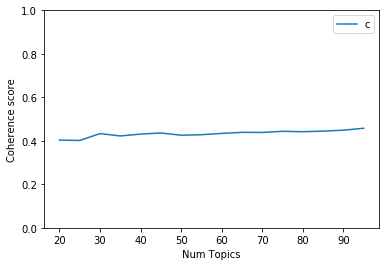

In [55]:
limit=100; start=20; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.ylim([0, 1])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Cluster titles by most dominant topic

In [114]:
from operator import itemgetter
from itertools import groupby

def cluster_titles_by_topic(ldamodel, corpus, titles):
    titles_topics = np.ndarray((len(titles),), dtype=int)
    for i, title_analysis in tqdm.tqdm(enumerate(ldamodel[corpus]), total=len(titles)):
        most_dominant_topic = max(title_analysis, key=itemgetter(1))
        topic_index = most_dominant_topic[0]
        titles_topics[i] = topic_index
    
    return titles_topics

best_model = model_list[-1]
titles_topics = cluster_titles_by_topic(ldamallet, corpus, processed_titles)
titles_topics


100%|██████████| 16306/16306 [00:00<00:00, 18753.22it/s]


array([93,  0, 56, ..., 73, 13,  9])

In [115]:
titles_with_clusters = sorted(zip(titles, titles_topics), key=itemgetter(1))
for topic_index, titles_with_index in groupby(titles_with_clusters, key=itemgetter(1)):
    print(f"Topic {topic_index} Keywords:")
    pprint(best_model.show_topic(topic_index))
    print("Titles:")
    titles_text = list(map(itemgetter(0), titles_with_index))
    pprint(titles_text[:10])
    print()

Topic 0 Keywords:
[('human', 0.62011236),
 ('poor', 0.080903895),
 ('information', 0.049371567),
 ('socio', 2.1259877e-05),
 ('lasagna', 2.1259877e-05),
 ('extremist', 2.1259877e-05),
 ('zealots', 2.1259877e-05),
 ('empire', 2.1259877e-05),
 ('immensely', 2.1259877e-05),
 ('crumble', 2.1259877e-05)]
Titles:
['CMV: The biggest issue in America is the economical system and general wage '
 'system.',
 'CMV: Proportional representation is a better system of democracy than single '
 'member plurality in almost every way.',
 'CMV: Review marks out of 5 is a far superior scoring system than any other.',
 'CMV: Democracy is not the best system of government',
 "CMV:Drug Users Aren't Bad People and Shouldn't be Punished so Harshly by the "
 'Criminal Justice System',
 'CMV: 01001110 01100101 01110110 01100101 01110010 00100000 01100111 01101111 '
 '01101110 01101110 01100001 00100000 01100111 01101001 01110110 01100101 '
 '00100000 01111001 01101111 01110101 00100000 01110101 01110000',
 'CMV:'

[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
["CMV: Prostitution is naturally harmful for women and shouldn't be just "
 '"another job"',
 "CMV: I don't think most millennials try hard enough to succeed nor is "
 'college more difficult than most corporate jobs',
 'CMV: It is not okay to have racial requirements for a job',
 'CMV: Whatever benefits we gain in terms of job creation with resolution 38 '
 'pale in comparison to the health risks posed by it.',
 'CMV: Using "Its the law" is OFTEN a straw man argument because laws are '
 'created to represent the morality of the people at the time they are created '
 'and get outdated with time.',
 'CMV: The United States of America needs to have a massive defensive budget, '
 'and honestly needs 

[('bad', 0.7735727),
 ('deal', 0.051279522),
 ('nature', 0.031825766),
 ('emotional', 0.02101776),
 ('zealots', 1.0417731e-05),
 ('crumble', 1.0417731e-05),
 ('socio', 1.0417731e-05),
 ('emergence', 1.0417731e-05),
 ('extremist', 1.0417731e-05),
 ('earning', 1.0417731e-05)]
Titles:
['CMV: Women who exchange SEX for Money/Power/Fame are Prostitutes',
 'CMV: I am uncomfortable with the idea of my boyfriend having PIV sex with my '
 'wife, but I want him to be able to.',
 'CMV: The act of cheating should be defined by what your partner considers '
 'cheating to be',
 "CMV: Being Transgendered Shouldn't Be Compared To Homosexuality",
 'CMV: Compassion is not useful or desirable to cultivate within yourself '
 'beyond what you already possess, and it may be useful to reduce your '
 'compassion',
 'CMV: Cheating in relationships should not be a problem. People should be '
 "able to have sex with any consenting adult, whether or not they're in a "
 'relationship.',
 'CMV: Americans divorce mo

[('would', 0.6178438),
 ('much', 0.14844847),
 ('bear', 0.04382509),
 ('nearly', 0.04013931),
 ('holocaust', 0.02298755),
 ('suggest', 0.019343195),
 ('presumptive', 9.150813e-06),
 ('emergence', 9.150813e-06),
 ('earning', 9.150813e-06),
 ('lasagna', 9.150813e-06)]
Titles:
['My encounter with Lucifer',
 "CMV: Women don't want to be treated like objects but to say we don't want to "
 'be viewed sexually sometimes is ridiculous and to be honest, absolutely '
 'insulting.',
 'Social Justice has a side that’s not discussed a lot. It promotes the victim '
 'mentality and hopelessness all the whole giving them a scapegoat to blame '
 'all their problems too.',
 'CMV: What Aziz Ansari did was gross and weird, but was not sexual assault.',
 "CMV:Actresses who kept quiet about Harvey Weinstein's abuse for decades, in "
 'exchange for money, fame and movies roles, are also in the wrong.',
 "I think we're all to blame.",
 'CMV:The charges against Roy Moore seem cynically timed, orchestrated and 

[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
['CMV: The best thing that someone can do to fight Trumpism is register to '
 'vote as a Republican and vote in the primaries.',
 'CMV I would rather vote for a third party candidate that is closer to my '
 'political standings rather than "the lesser of two evils"',
 'CMV: It should be illegal for politicians to seek higher office while in '
 'office. Resignation or refusal to run again to seek another office should be '
 'mandatory.',
 'How about "no party" system. It yields nothing but chao',
 'Why should I run a marathon ?',
 'CMV: I think everybody should take and pass a test before they are allowed '
 'to vote.',
 'CMV: Concealed carry should be legal after absolving multiple tests and a '
 

 'CMV: There is no truly unselfish deed, in the end we do everything for '
 'ourselves.',
 'CMV: Anthropomorphic view of the world. Everything is for human survival and '
 'animals only matter to the extent that they serve us and keep their own '
 'population in check.',
 'CMV: I would pay extra to have "black people free" movie screenings',
 "CMV: The reason people aren't successful is because they are scared to do "
 'what they want to',
 'The purpose of all life is to generate suffering']

Topic 48 Keywords:
[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
['CMV: Women who fear random men are being sexist and propagating illogical '
 'fear',
 'Christian Rap is NOT ALL corny and judgemental',
 'CMV:Statements of the form "&lt;thing&gt; is offe

 'women. Considering then feminist is regressive',
 'Change my view of male privilege.',
 'CMV: I believe Toothpaste should be changed to Teethpaste.',
 "CMV: The 'Left' vs 'Right' In politics could be better summarized as change "
 'vs stability']

Topic 57 Keywords:
[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
["CMV: I don't think hyperrealistic paintings are interesting art",
 'CMV: I think hiphop music sucks',
 'CMV: I shouldn’t have to pay a cover to see bands I’ve never heard of at a '
 'bar',
 'CMV: Classical music is completely useless to society in 2017.',
 'CMV: Wood is literally the worst material for arts and crafts',
 'CMV: I think Dwayne "The Rock" Johnson is a bad actor',
 'CMV: It is appropriate to categorize "Art with a mess

[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
["CMV: Waitstaff's salary should come from employer, not customers via "
 'gratuity.',
 'CMV: "Pre-tips" for online orders are wrong and put the customer in unfair '
 'situation.',
 'CMV: Employers should pay Waitstaff minimum wage instead of subsidizing '
 'their wage with tips.',
 "CMV: Speaking highly of a company's product or service on reddit does not "
 'make someone a shill, thus makes r/hailcorporate tags unwarranted.',
 'Voting should be mandatory',
 'CMV: Black Lives Matter Toronto were justified in asking for the Toronto '
 'Police Service to be removed from Pride celebrations, and TPS are in the '
 'wrong for asking for funding to be removed',
 'CMV: All medicine should be available fo

[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
['CMV: The left could never defeat the right with violence and it is stupid to '
 'even try',
 'CMV: In "Gone Girl", Nick should either kill Amy, leave her regardless of '
 'what she can do to his reputation, or commit suicide',
 'CMV: Kevin Stacey’s reputation should not be dragged through the dirt as '
 'there have been no legal proceedings proving his guilt',
 "CMV: Suicide isn't a selfish act.",
 'CMV: Left and Right is a vague concept.',
 'CMV: I don’t believe in suicide',
 'CMV: A non-plutocratic oligarchy is the most viable form of governing',
 'CMV: The Argument Against Assisted Suicide',
 'CMV: The Left is so violent',
 'CMV: Euthanasia should not be legal because of religion']

Topic 74 

[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
['Humans are innately selfish. Every human behavior is done in self-interest.',
 'CMV: Gangsters and wannabe gangsters, are degenerate filth and deserve to '
 'die.',
 "CMV: What Lena Dunham did to her sister wasn't rape, or sexual assault, but "
 'a rather normal (and very awkward) part of learning about the human body.',
 'CMV: Legal Rights should be limited to humans only.',
 'CMV: Killing another human being is never justified.',
 'CMV: Urban western citizens cannot do anything about climate change',
 'CMV: Some Individuals with Downs Syndrome are "Technically" part of a '
 'different species (please read before you downvote)',
 'CMV: All humans are selfish',
 'CMV:Humans still have the "repti

 'CMV: Beyoncé naming her child Rumi is cultural appropriation, and she should '
 'be getting much more criticism from social justice communities.',
 'CMV: The public are being encouraged to behave in certain ways which '
 'distracts them from rational and reality-based subjects of protest.',
 'CMV: BCE and CE are cultural appropriation of Christian culture',
 "CMV: Alex19 isn't so great."]

Topic 92 Keywords:
[('emergence', 8.514985e-05),
 ('presumptive', 8.514985e-05),
 ('escalation', 8.514985e-05),
 ('merge', 8.514985e-05),
 ('crumble', 8.514985e-05),
 ('empire', 8.514985e-05),
 ('extremist', 8.514985e-05),
 ('zealots', 8.514985e-05),
 ('socio', 8.514985e-05),
 ('lasagna', 8.514985e-05)]
Titles:
['CMV: I heard about the thought experiment "Roko\'s Basilisk" and it\'s '
 'making me nervous.',
 'CMW: The vast majority of the world is evil and they’re digging all of our '
 'graves. There is no fixing it since nobody cares.',
 'CMV: You Can\'t "Feel" Like the Opposite Sex',
 'CMV: The T

IndexError: index 95 is out of bounds for axis 0 with size 95